In [110]:
# %matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from matplotlib import style

In [150]:
# some constants we need

linestyles = ['solid', 'densely dotted', 'densely dashed', 'densely dashdotted']
markerstyles = ['o', '^', 'v', 's', 'P', 'X']
labelloc = [4, 4, 1, 1]

# file lists
artifacts_path = "../../artifacts/chep/metric_learning/"

metrics_file = "metrics.csv"
yaml_file  = "hparams.yaml"

# standard MLP ones
mlp_reference = "reference/version_8/"
mlp_batchnorm = "batchnorm/version_0/"
mlp_batch_noNorm = "batchnorm_no_norm/version_0/"
# pruning of standard MLP
mlp_prune_unstructured_noL1     = "batchnorm_no_norm_prune_unstructured_noL1/version_0/"
mlp_prune_unstructured_wL1      = "batchnorm_no_norm_prune_unstructured_noL1/version_1/"
mlp_prune_structured_wL1_dim1   = "batchnorm_no_norm_prune_structured_wL1/version_1/"
mlp_prune_structured_noL1       = "batchnorm_no_norm_prune_structured_noL1/version_0/"
mlp_prune_structured_wL1_dim0   = "batchnorm_no_norm_prune_structured_wL1/version_2/"
# input quantization in standard MLP; these are sweeps, to be seen how to do!
mlp_input_integer    = "batchnorm_no_norm_inputQuant_integer/version_"
mlp_input_fractional = "batchnorm_no_norm_inputQuant_frac/version_"
# activation quantization: sweep
qmlp_activation_sweep = "batchnorm_no_norm_QMLP_sweep_act/version_"
qmlp_activation_sweep_replace_bops_dir = "batchnorm_no_norm_QMLP_sweep_act_bops/version_"
# weight sweep
qmlp_weight_sweep = "batchnorm_no_norm_QMLP_sweep_weights_new/version_"
# qmlp pruning
qmlp_prune_unstructured_L1_optimized = "batchnorm_no_norm_QMLP_optimized_pruned_L1/version_0/"
qmlp_prune_unstructured_L1_act8_w4 = "batchnorm_no_norm_QMLP_optimized_pruned_L1/version_1/"
qmlp_prune_unstructured_L1_act8_w424 = "batchnorm_no_norm_QMLP_optimized_pruned_L1/version_2/"


#files_mlp = [mlp_reference, mlp_batchnorm, mlp_batch_noNorm]
files_mlp = [mlp_batch_noNorm]
#label_files_mlp = ["MLP Layernorm w Normalization",
#                   "MLP Batchnorm w Normalization",
#                   "MLP Batchnorm w/o Normalization"]
label_files_mlp = ["PyTorch MLP"]
files_mlp_pruned = [mlp_prune_unstructured_noL1, 
                    mlp_prune_unstructured_wL1, 
                    mlp_prune_structured_wL1_dim1, 
                    mlp_prune_structured_noL1, 
                    mlp_prune_structured_wL1_dim0]      
label_files_mlp_prune = ["L1 unstructured, no L1 loss", 
                         "PyTorch MLP L1 unstructured, with L1 loss", 
                         "L1 structured (dim = 1), with L1 loss",
                         "L1 structured (dim = 1), no L1 loss",
                         "L1 structured (dim = 0), with L1 loss"]
# QMLP: quantized weights and activations, no bias!
files_qmlp_pruned = [qmlp_prune_unstructured_L1_optimized, 
                    qmlp_prune_unstructured_L1_act8_w4, 
                    qmlp_prune_unstructured_L1_act8_w424]
#label_files_qmlp_prune = ["L1 unstructured, L1 loss, w = (5,3,4), a = (7,5,6)", 
#                          "L1 unstructured, L1 loss, w = (4,4,4), a = (8,8,8)",
#                          "L1 unstructured, L1 loss, w = (4,2,4), a = (8,8,8)"]
label_files_qmlp_prune = ["w = (5,3,4), a = (7,5,6)", 
                          "w = (4,4,4), a = (8,8,8)",
                          "w = (4,2,4), a = (8,8,8)"]


obs = {0:"val_loss",
       1:"eff",
       2:"pur",
       3:"current_lr",
       4:"R95",
       5:"R98",
       6:"R99",
       7:"pur_95",
       8:"pur_98",
       9:"pur_99",
       10:"total_bops",
       11:"total_mem_w_bits",
       12:"total_mem_o_bits",
       13:"pruned",
       14:"epoch",
       15:"step",
       16:"train_loss"
      }
label_obs = {0:"Validation loss",
             1:"Efficiency",
             2:"Purity",
             3:"Current learning rate",
             4:"Radius for 95% efficiency",
             5:"Radius for 98% efficiency",
             6:"Radius for 99% efficiency",
             7:"Purity at 95% efficiency",
             8:"Purity at 98% efficiency",
             9:"Purity at 99% efficiency",
             10:"BOPs per cluster/event",
             11:"Memory bits (weights)",
             12:"Memory bits (output, per cluster)",
             13:"Number of pruning steps",
             14:"Epoch",
             15:"Training step",
             16:"Training loss"
      }

reference_label = "PyTorch reference"

In [112]:
def filter_nan(arr): 
     """The way csv file is created for qnn networks, contain some 'nans'
    Therefore I created a function to remove 'nan' from the csv file array"""
     index =np.where( np.isnan(arr)==0)
     filter_arr = arr[index]
     return filter_arr;

def return_final_purities(file_list):
    labels = ['pur_95', 'pur_98', 'pur_99']
    pur95 = []
    pur98 = []
    pur99 = []
    purs = [pur95, pur98, pur99]
    for current_file in file_list:
        csv_path = f"{artifacts_path}{current_file}{metrics_file}"
        with open(csv_path) as file:
            metrics = pd.read_csv(file)
        for purity, label in zip (purs, labels):
            purity.append(filter_nan(np.array(metrics[label]))[-1]) # taking last value: index -1
    return purs

def return_initial_bops(file_w_bops):
    label = ['total_bops']
    csv_path = f"{file_w_bops}{metrics_file}"
    with open(csv_path) as file:
        metrics = pd.read_csv(file)
    return(filter_nan(np.array(metrics[label]))[0]) # taking first value

def purities_vs_bops(current_file):
    labels = ['pur_95', 'pur_98', 'pur_99', 'total_bops']
    pur95 = []
    pur98 = []
    pur99 = []
    bops  = []
    purs = [pur95, pur98, pur99, bops]
    csv_path = f"{artifacts_path}{current_file}{metrics_file}"
    with open(csv_path) as file:
        metrics = pd.read_csv(file)
        pruned_array = filter_nan(np.array(metrics["pruned"]))
        index_list = []
        last_pruned = 0
        for i in range(len(pruned_array)):
            if(pruned_array[i] > last_pruned):
                index_list.append(i-1)
            last_pruned = pruned_array[i]
        for purity, label in zip (purs, labels):
            if index_list == []:
                purity.append(filter_nan(np.array(metrics[label]))[-1]) # taking last value: index -1
            for index in index_list :
                purity.append(filter_nan(np.array(metrics[label]))[index]) # taking last value: index -1
    return purs

def purities_bops_vs_config(sweep_dir, num_scans, config_key, skip=[]):
    labels = ['pur_95', 'pur_98', 'pur_99', 'total_bops']
    pur95 = []
    pur98 = []
    pur99 = []
    bops = []
    config = []
    purs = [pur95, pur98, pur99, bops]
    for i in range(num_scans):
        if i in skip:
            print(f"skip {i}")
            continue
        current_file = f"{sweep_dir}{i}/"
        yaml_path = f"{artifacts_path}{current_file}{yaml_file}"
        csv_path = f"{artifacts_path}{current_file}{metrics_file}"
        with open(csv_path) as file:
            metrics = pd.read_csv(file)
        for purity, label in zip (purs, labels):
            purity.append(filter_nan(np.array(metrics[label]))[-1]) # taking last value: index -1
        with open(yaml_path) as file:
            all_configs = yaml.load(file, Loader=yaml.FullLoader)
            config.append(all_configs[config_key])
                #print(f"config_key: {config_key} all_configs[config_key]: {all_configs[config_key]}")
    purs.append(config)
    return purs

def purities_bops_vs_configs(sweep_dir, num_scans, config_keys, skip=[]):
    labels = ['pur_95', 'pur_98', 'pur_99', 'total_bops']
    pur95 = []
    pur98 = []
    pur99 = []
    bops = []
    config = []
    purs = [pur95, pur98, pur99, bops]
    for i in range(num_scans):
        if i in skip:
            print(f"skip {i}")
            continue
        configs = []
        current_file = f"{sweep_dir}{i}/"
        yaml_path = f"{artifacts_path}{current_file}{yaml_file}"
        csv_path = f"{artifacts_path}{current_file}{metrics_file}"
        with open(csv_path) as file:
            metrics = pd.read_csv(file)
            if(filter_nan(np.array(metrics['pur_99']))[-1]<0.025):
               continue
        for purity, label in zip (purs, labels):
            purity.append(filter_nan(np.array(metrics[label]))[-1]) # taking last value: index -1
        with open(yaml_path) as file:
            all_configs = yaml.load(file, Loader=yaml.FullLoader)
            for config_key in config_keys:
                configs.append(all_configs[config_key])
                #print(f"config_key: {config_key} all_configs[config_key]: {all_configs[config_key]}")
        config.append(configs)
    purs.append(config)
    return purs

def replace_bops(pur_file, replace_dir, num_scans, config_keys, skip=[]):
    output_list = pur_file
    index = 0
    for bops, config in zip (output_list[3], output_list[4]):    # config is [4]
        print(f"config: {config}")
        if(bops < 800000000):
            print("bops smaller 800000000")
            continue
        for i in range(num_scans):
            if i in skip:
                print(f"skip {i}")
                continue
            current_file = f"{replace_dir}{i}/"
            yaml_path = f"{artifacts_path}{current_file}{yaml_file}"
            with open(yaml_path) as file:
                all_configs = yaml.load(file, Loader=yaml.FullLoader)
                found = True
                for config_key, config_value in zip (config_keys, config):
                    if(all_configs[config_key] != config_value):
                        found = False
                if found:
                    csv_path = f"{artifacts_path}{current_file}"
                    print(f"found_config: {yaml_path}")
                    output_list[3][index] = return_initial_bops(csv_path)
                    continue
        index = index + 1
        print(index)
    return output_list


In [152]:
reference_purities = return_final_purities(files_mlp)
ref_vs_bops = []
for file in files_mlp:
    ref_vs_bops.append(purities_vs_bops(file))
pur_vs_bops = []
for file in files_mlp_pruned:
    pur_vs_bops.append(purities_vs_bops(file))
#print(pur_vs_bops[0][0]) #[file][metric]
print(ref_vs_bops)

pur_vs_int = purities_bops_vs_config(mlp_input_integer, 8, "integer_part")
pur_vs_fra = purities_bops_vs_config(mlp_input_fractional, 26, "fractional_part", skip=[9,22])
pur_qmlp_activation_sweep = purities_bops_vs_configs(qmlp_activation_sweep, 
                                                 343, 
                                                 ["activation_bit_width_input", 
                                                  "activation_bit_width_hidden",
                                                  "activation_bit_width_output"], 
                                                  skip=[])
print(pur_qmlp_activation_sweep)

pur_qmlp_weight_sweep = purities_bops_vs_configs(qmlp_weight_sweep, 
                                                 21, 
                                                 ["weight_bit_width_input", 
                                                  "weight_bit_width_hidden",
                                                  "weight_bit_width_output"], 
                                                  skip=[])


print(pur_vs_int)
print(pur_vs_fra)

purity_labels = [label_obs[7], label_obs[8], label_obs[9]]
reference = ref_vs_bops[0]

qmlp_pur_vs_bops = []
for file in files_qmlp_pruned:
    qmlp_pur_vs_bops.append(purities_vs_bops(file))
#print(pur_vs_bops[0][0]) #[file][metric]
print(qmlp_pur_vs_bops)


[[[0.317711740732193], [0.2227185368537902], [0.1613043248653412], [817889344.0]]]
skip 9
skip 22
[[0.0876426920294761, 0.0894164741039276, 0.1025861203670501, 0.140983372926712, 0.1577954441308975, 0.1501628011465072, 0.1586942225694656, 0.121880441904068, 0.1541144102811813, 0.1649246364831924, 0.1586591005325317, 0.1618208438158035, 0.1248576119542121, 0.1583926230669021, 0.1772743314504623, 0.1669686287641525, 0.0933533757925033, 0.0940320342779159, 0.0948149040341377, 0.1081129312515258, 0.1153621599078178, 0.172855943441391, 0.1655788570642471, 0.1785385012626648, 0.1739975810050964, 0.1658545136451721, 0.2055859714746475, 0.2146536409854889, 0.2186361253261566, 0.1618383973836898, 0.1788774877786636, 0.212049663066864, 0.2396096289157867, 0.2403301149606704, 0.2422579377889633, 0.1831101924180984, 0.2171259373426437, 0.2358262538909912, 0.2483492493629455, 0.171455830335617, 0.0588905923068523, 0.0948609113693237, 0.1167658865451812, 0.1238667145371437, 0.1107805967330932, 0.138

In [114]:
print(pur_qmlp_activation_sweep)
pur_qmlp_activation_sweep = replace_bops(pur_qmlp_activation_sweep, 
                                         #qmlp_activation_sweep,
                                         qmlp_activation_sweep_replace_bops_dir, 
                                         343, 
                                         ["activation_bit_width_input", 
                                         "activation_bit_width_hidden",
                                         "activation_bit_width_output"], 
                                         skip=[])
print(pur_qmlp_activation_sweep[3])

[[0.0876426920294761, 0.0894164741039276, 0.1025861203670501, 0.140983372926712, 0.1577954441308975, 0.1501628011465072, 0.1586942225694656, 0.121880441904068, 0.1541144102811813, 0.1649246364831924, 0.1586591005325317, 0.1618208438158035, 0.1248576119542121, 0.1583926230669021, 0.1772743314504623, 0.1669686287641525, 0.0933533757925033, 0.0940320342779159, 0.0948149040341377, 0.1081129312515258, 0.1153621599078178, 0.172855943441391, 0.1655788570642471, 0.1785385012626648, 0.1739975810050964, 0.1658545136451721, 0.2055859714746475, 0.2146536409854889, 0.2186361253261566, 0.1618383973836898, 0.1788774877786636, 0.212049663066864, 0.2396096289157867, 0.2403301149606704, 0.2422579377889633, 0.1831101924180984, 0.2171259373426437, 0.2358262538909912, 0.2483492493629455, 0.171455830335617, 0.0588905923068523, 0.0948609113693237, 0.1167658865451812, 0.1238667145371437, 0.1107805967330932, 0.1384342610836029, 0.1791159808635711, 0.1883767545223236, 0.2057369798421859, 0.2182942032814026, 0.1

0.317711740732193


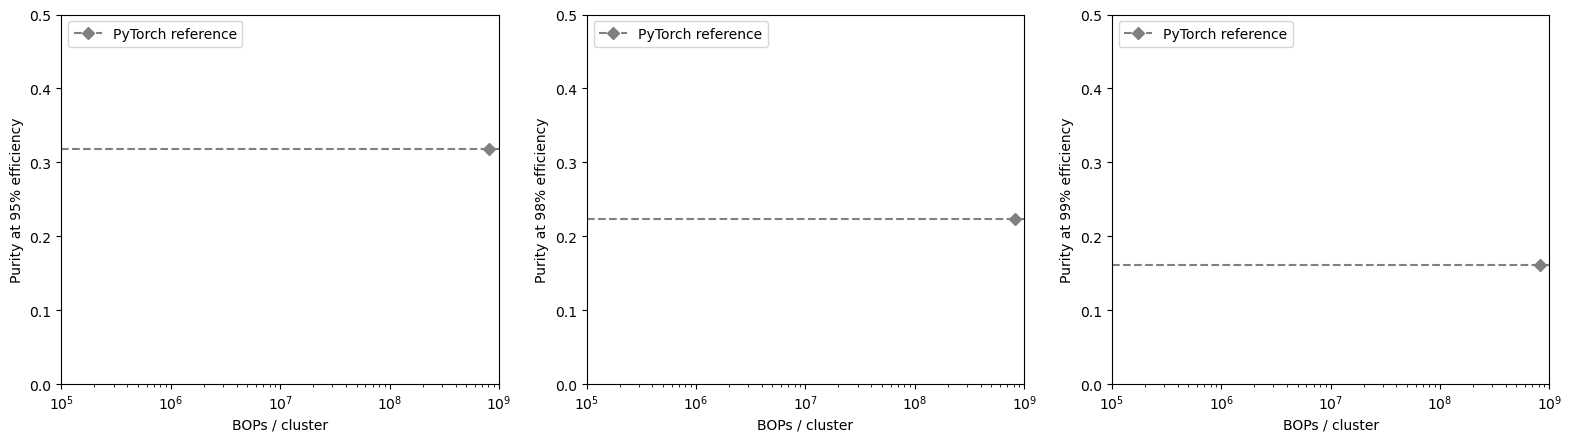

In [155]:
fig = plt.figure(figsize=(19.2,4.8))
ax1 = fig.add_subplot(131)
print(reference[0][0])
ax1.axline((1e8,reference[0][0]),(1e9,reference[0][0]),linestyle = 'dashed', color = "gray")
ax2 = fig.add_subplot(132)
ax2.axline((1e8,reference[1][0]),(1e9,reference[1][0]),linestyle = 'dashed', color = "gray")
ax3 = fig.add_subplot(133)
ax3.axline((1e8,reference[2][0]),(1e9,reference[2][0]),linestyle = 'dashed', color = "gray")
ax_list = [ax1, ax2, ax3]

x_min = 1e5
x_max = 1e9
y_min = 0
y_max = 0.5

# references only
for pur_file, graph_label in zip(ref_vs_bops, label_files_mlp):
    for ax, lab, pur in zip (ax_list, purity_labels, pur_file):
        ax.set_ylabel(lab)
        ax.set_xscale('log')
        ax.set_ylim(y_min,y_max)
        ax.set_xlim(x_min,x_max)
        ax.set_xlabel("BOPs / cluster")
        ax.plot(pur_file[3],pur, label = reference_label, alpha=1, marker = "D", linestyle="dashed", color = "gray") #, linestyle=linestyles[idfile%3], marker = markerstyles[idfile%3]) ##plotting )
        ax.legend(loc=2, prop={'size': 10})



0.317711740732193


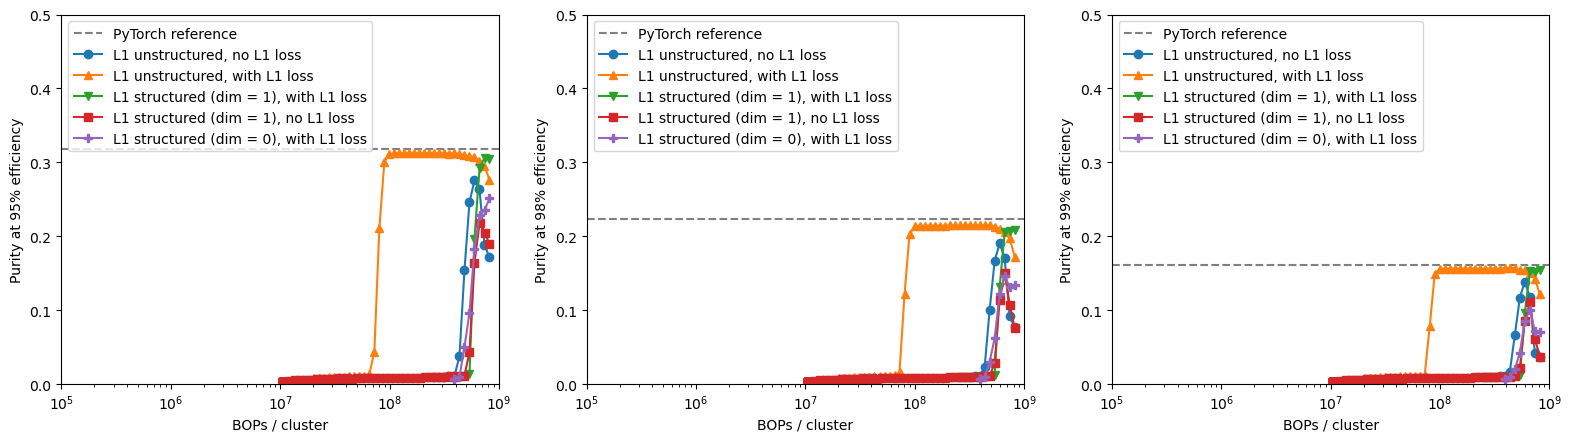

In [116]:

fig = plt.figure(figsize=(19.2,4.8))
ax1 = fig.add_subplot(131)
print(reference[0][0])
ax1.axline((1e8,reference[0][0]),(1e9,reference[0][0]),linestyle = 'dashed', color = "gray", label = reference_label)
ax2 = fig.add_subplot(132)
ax2.axline((1e8,reference[1][0]),(1e9,reference[1][0]),linestyle = 'dashed', color = "gray", label = reference_label)
ax3 = fig.add_subplot(133)
ax3.axline((1e8,reference[2][0]),(1e9,reference[2][0]),linestyle = 'dashed', color = "gray", label = reference_label)
ax_list = [ax1, ax2, ax3]

# pruned MLP with references
index = 0
for pur_file, graph_label  in zip(pur_vs_bops, label_files_mlp_prune):
    for ax, lab, pur, ref_pur in zip (ax_list, purity_labels, pur_file, reference):
        ax.set_ylabel(lab)
        ax.set_xscale('log')
        ax.set_ylim(y_min,y_max)
        ax.set_xlim(x_min,x_max)
        ax.set_xlabel("BOPs / cluster")
        ax.plot(pur_file[3],pur, label = graph_label, alpha=1, marker=markerstyles[index]) #, linestyle=linestyles[idfile%3], marker = markerstyles[idfile%3]) ##plotting )
        ax.legend(loc=2, prop={'size': 10})
    index = index + 1


0.317711740732193


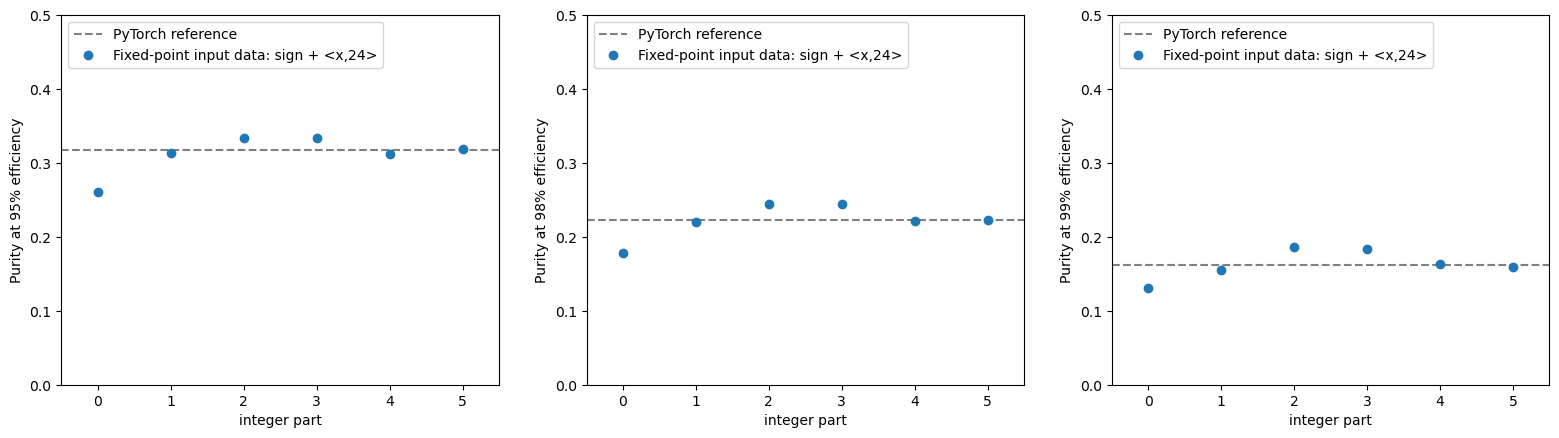

In [122]:


fig = plt.figure(figsize=(19.2,4.8))
ax1 = fig.add_subplot(131)
print(reference[0][0])
ax1.axline((1e8,reference[0][0]),(1e9,reference[0][0]),linestyle = 'dashed', color = "gray", label = reference_label)
ax2 = fig.add_subplot(132)
ax2.axline((1e8,reference[1][0]),(1e9,reference[1][0]),linestyle = 'dashed', color = "gray", label = reference_label)
ax3 = fig.add_subplot(133)
ax3.axline((1e8,reference[2][0]),(1e9,reference[2][0]),linestyle = 'dashed', color = "gray", label = reference_label)
ax_list = [ax1, ax2, ax3]


for ax, lab, pur, ref_pur in zip (ax_list, purity_labels, pur_vs_int, reference):
    ax.set_ylabel(lab)
    ax.set_ylim(y_min,y_max)
    ax.set_xlim(-0.5,5.5)
    ax.set_xlabel("integer part")
    ax.plot(pur_vs_int[4],pur, label = "Fixed-point input data: sign + <x,24>", alpha=1, linestyle="None", marker = "o") ##plotting )
    ax.legend(loc=2, prop={'size': 10})


0.317711740732193


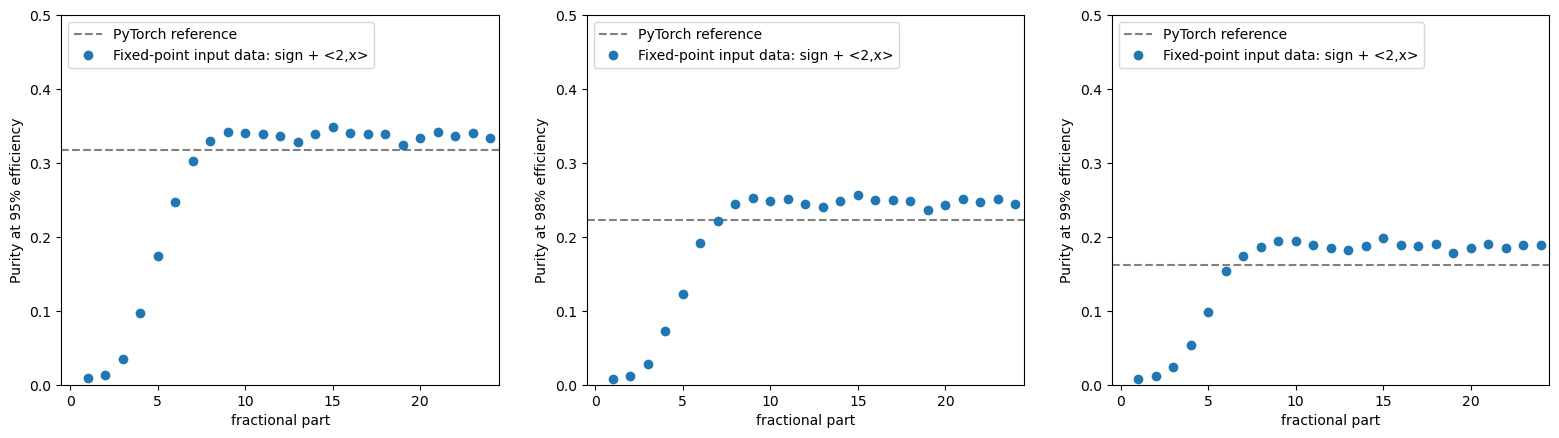

In [123]:


fig = plt.figure(figsize=(19.2,4.8))
ax1 = fig.add_subplot(131)
print(reference[0][0])
ax1.axline((1e8,reference[0][0]),(1e9,reference[0][0]),linestyle = 'dashed', color = "gray", label = reference_label)
ax2 = fig.add_subplot(132)
ax2.axline((1e8,reference[1][0]),(1e9,reference[1][0]),linestyle = 'dashed', color = "gray", label = reference_label)
ax3 = fig.add_subplot(133)
ax3.axline((1e8,reference[2][0]),(1e9,reference[2][0]),linestyle = 'dashed', color = "gray", label = reference_label)
ax_list = [ax1, ax2, ax3]
  
for ax, lab, pur, ref_pur  in zip (ax_list, purity_labels, pur_vs_fra, reference):
    ax.set_ylabel(lab)
    ax.set_ylim(0,0.5)
    ax.set_xlim(-0.5,24.5)
    ax.set_xlabel("fractional part")
    ax.plot(pur_vs_fra[4],pur, label = "Fixed-point input data: sign + <2,x>", alpha=1, linestyle="None", marker = "o") ##plotting )
    ax.legend(loc=2, prop={'size': 10})



0.317711740732193
[[5, 4, 5], [4, 5, 5], [5, 5, 4], [5, 5, 5]]
[[5, 4, 6], [6, 4, 4], [6, 4, 5], [6, 4, 6], [4, 5, 6], [5, 5, 6], [6, 5, 4], [6, 5, 5], [6, 5, 6], [4, 6, 4], [4, 6, 5], [4, 6, 6], [5, 6, 4], [5, 6, 5], [5, 6, 6], [6, 6, 4], [6, 6, 5], [6, 6, 6]]
[[6, 4, 7], [7, 4, 4], [7, 4, 5], [7, 4, 6], [7, 4, 7], [4, 5, 7], [5, 5, 7], [6, 5, 7], [7, 5, 4], [7, 5, 5], [7, 5, 6], [7, 5, 7], [4, 6, 7], [5, 6, 7], [6, 6, 7], [7, 6, 4], [7, 6, 5], [7, 6, 6], [7, 6, 7], [4, 7, 4], [4, 7, 5], [4, 7, 6], [4, 7, 7], [5, 7, 4], [5, 7, 5], [5, 7, 6], [5, 7, 7], [6, 7, 4], [6, 7, 5], [6, 7, 6], [6, 7, 7], [7, 7, 4], [7, 7, 5], [7, 7, 6], [7, 7, 7], [5, 4, 7]]
[[6, 4, 8], [7, 4, 8], [8, 4, 4], [8, 4, 5], [8, 4, 6], [8, 4, 7], [4, 5, 8], [5, 5, 8], [6, 5, 8], [7, 5, 8], [8, 5, 4], [8, 5, 5], [8, 5, 6], [8, 5, 7], [8, 5, 8], [4, 6, 8], [5, 6, 8], [6, 6, 8], [7, 6, 8], [8, 6, 4], [8, 6, 5], [8, 6, 6], [8, 6, 7], [8, 6, 8], [4, 7, 8], [5, 7, 8], [6, 7, 8], [7, 7, 8], [8, 7, 4], [8, 7, 5], [8, 7, 6],

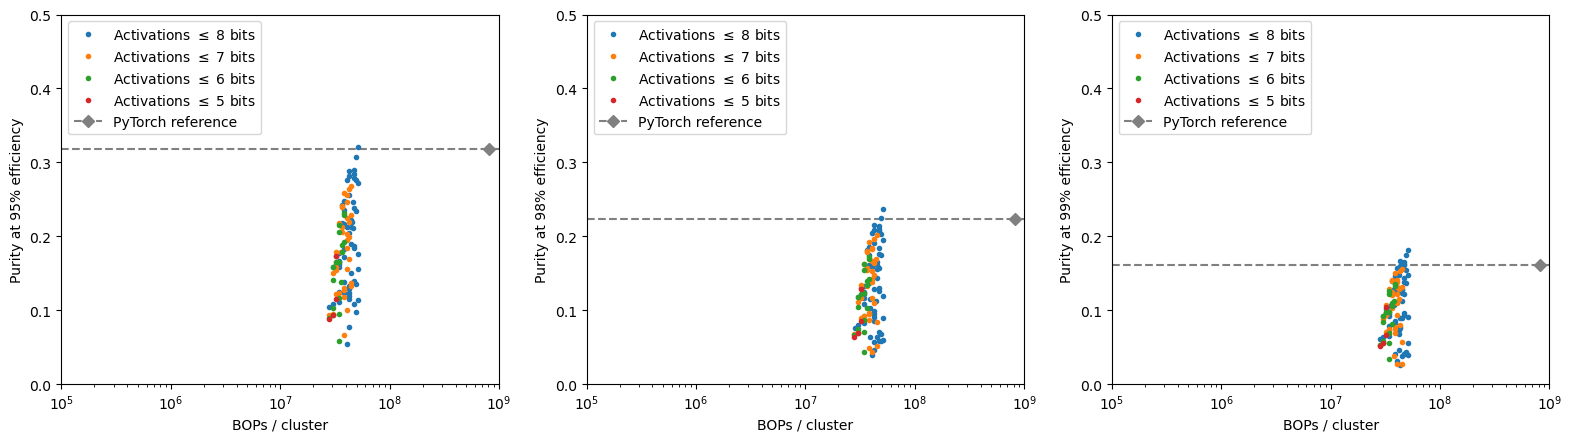

In [141]:


fig = plt.figure(figsize=(19.2,4.8))
ax1 = fig.add_subplot(131)
print(reference[0][0])
ax1.axline((1e8,reference[0][0]),(1e9,reference[0][0]),linestyle = 'dashed', color = "gray")
ax2 = fig.add_subplot(132)
ax2.axline((1e8,reference[1][0]),(1e9,reference[1][0]),linestyle = 'dashed', color = "gray")
ax3 = fig.add_subplot(133)
ax3.axline((1e8,reference[2][0]),(1e9,reference[2][0]),linestyle = 'dashed', color = "gray")
ax_list = [ax1, ax2, ax3]

def cut_config (source, bits, all_smaller):  
    pur_qmlp_activation_sweep_max = [[],[],[],[],[]]
    p = source[4]
    index = 0
    for q in p:
        okay = True
        smaller_count = 0
        for a in q:
            if (a > bits):
                okay = False
            if (a < all_smaller):
                smaller_count = smaller_count + 1
        if (okay and smaller_count <3):
            i = 0
            for  drain in source:
                pur_qmlp_activation_sweep_max[i].append(drain[index])
                i = i +1
        index = index + 1
    return pur_qmlp_activation_sweep_max

pur_qmlp_activation_sweep_max5 = cut_config(pur_qmlp_activation_sweep, 5, 0)
pur_qmlp_activation_sweep_max6 = cut_config(pur_qmlp_activation_sweep, 6, 6)
pur_qmlp_activation_sweep_max7 = cut_config(pur_qmlp_activation_sweep, 7, 7)
pur_qmlp_activation_sweep_max8 = cut_config(pur_qmlp_activation_sweep, 8, 8)

print(pur_qmlp_activation_sweep_max5[4])
print(pur_qmlp_activation_sweep_max6[4])
print(pur_qmlp_activation_sweep_max7[4])
print(pur_qmlp_activation_sweep_max8[4])
 
 

for ax, lab, pur, pur_max5, pur_max6, pur_max7, pur_max8, ref  in zip (ax_list, purity_labels, pur_qmlp_activation_sweep, pur_qmlp_activation_sweep_max5, pur_qmlp_activation_sweep_max6, pur_qmlp_activation_sweep_max7, pur_qmlp_activation_sweep_max8, reference):
    ax.set_ylabel(lab)
    ax.set_xscale('log')
    ax.set_ylim(y_min,y_max)
    ax.set_xlim(x_min,x_max)
    ax.set_xlabel("BOPs / cluster")
    ax.plot(pur_qmlp_activation_sweep_max8[3], pur_max8, label = "Activations $\leq$ 8 bits", alpha=1, linestyle="None", marker = ".") ##plotting )
    ax.plot(pur_qmlp_activation_sweep_max7[3], pur_max7, label = "Activations $\leq$ 7 bits", alpha=1, linestyle="None", marker = ".") ##plotting )
    ax.plot(pur_qmlp_activation_sweep_max6[3], pur_max6, label = "Activations $\leq$ 6 bits", alpha=1, linestyle="None", marker = ".") ##plotting )
    ax.plot(pur_qmlp_activation_sweep_max5[3], pur_max5, label = "Activations $\leq$ 5 bits", alpha=1, linestyle="None", marker = ".") ##plotting )
    ax.plot(reference[3], ref, label = reference_label, alpha=1, marker = "D", linestyle="dashed", color = "gray")
    ax.legend(loc=2, prop={'size': 10})    

0.317711740732193
[[8, 2, 8], [8, 3, 8], [8, 4, 8], [8, 5, 8], [8, 6, 8], [8, 7, 8], [8, 8, 8]]
[[8, 3, 2], [8, 3, 3], [8, 3, 4], [8, 3, 5], [8, 3, 6], [8, 3, 7], [8, 3, 8]]
[[2, 3, 4], [3, 3, 4], [4, 3, 4], [5, 3, 4], [6, 3, 4], [7, 3, 4], [8, 3, 4]]


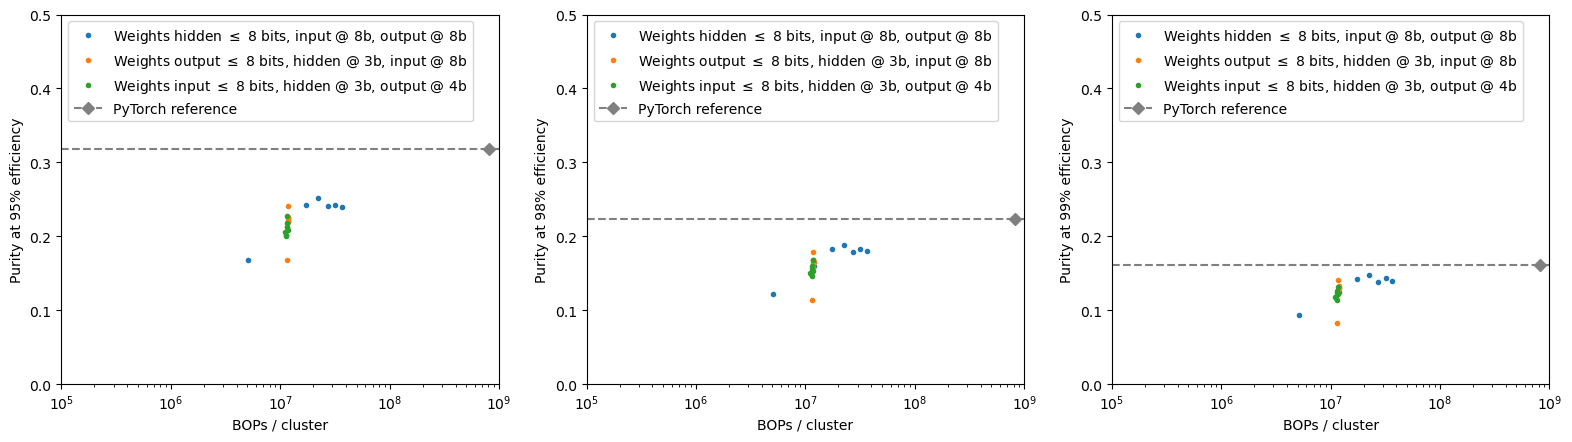

In [142]:

fig = plt.figure(figsize=(19.2,4.8))
ax1 = fig.add_subplot(131)
print(reference[0][0])
ax1.axline((1e8,reference[0][0]),(1e9,reference[0][0]),linestyle = 'dashed', color = "gray")
ax2 = fig.add_subplot(132)
ax2.axline((1e8,reference[1][0]),(1e9,reference[1][0]),linestyle = 'dashed', color = "gray")
ax3 = fig.add_subplot(133)
ax3.axline((1e8,reference[2][0]),(1e9,reference[2][0]),linestyle = 'dashed', color = "gray")
ax_list = [ax1, ax2, ax3]

def cut_list (source, start, end):  # split 7, 7, 7
    cut_list = [[],[],[],[],[]]
    index = 0
    for p in source:
        cut_list[index] = p[start:end]
        index = index + 1
    return cut_list

pur_qmlp_weight_sweep_hidden = cut_list(pur_qmlp_weight_sweep, 0,7)
pur_qmlp_weight_sweep_output = cut_list(pur_qmlp_weight_sweep, 7,14)
pur_qmlp_weight_sweep_input = cut_list(pur_qmlp_weight_sweep, 14,21)
print(pur_qmlp_weight_sweep_hidden[4])
print(pur_qmlp_weight_sweep_output[4])
print(pur_qmlp_weight_sweep_input[4])

for ax, lab, pur_h, pur_o, pur_i, ref in zip (ax_list, purity_labels, pur_qmlp_weight_sweep_hidden, pur_qmlp_weight_sweep_output, pur_qmlp_weight_sweep_input, reference):
    ax.set_ylabel(lab)
    ax.set_xscale('log')
    ax.set_ylim(y_min,y_max)
    ax.set_xlim(x_min,x_max)
    ax.set_xlabel("BOPs / cluster")
    ax.plot(pur_qmlp_weight_sweep_hidden[3], pur_h, label = "Weights hidden $\leq$ 8 bits, input @ 8b, output @ 8b", alpha=1, linestyle="None", marker = ".") ##plotting )
    ax.plot(pur_qmlp_weight_sweep_output[3], pur_o, label = "Weights output $\leq$ 8 bits, hidden @ 3b, input @ 8b", alpha=1, linestyle="None", marker = ".") ##plotting )
    ax.plot(pur_qmlp_weight_sweep_input[3], pur_i, label = "Weights input $\leq$ 8 bits, hidden @ 3b, output @ 4b", alpha=1, linestyle="None", marker = ".") ##plotting )
    ax.plot(reference[3], ref, label = reference_label, alpha=1, marker = "D", linestyle="dashed", color = "gray")
    ax.legend(loc=2, prop={'size': 10})    

0.317711740732193


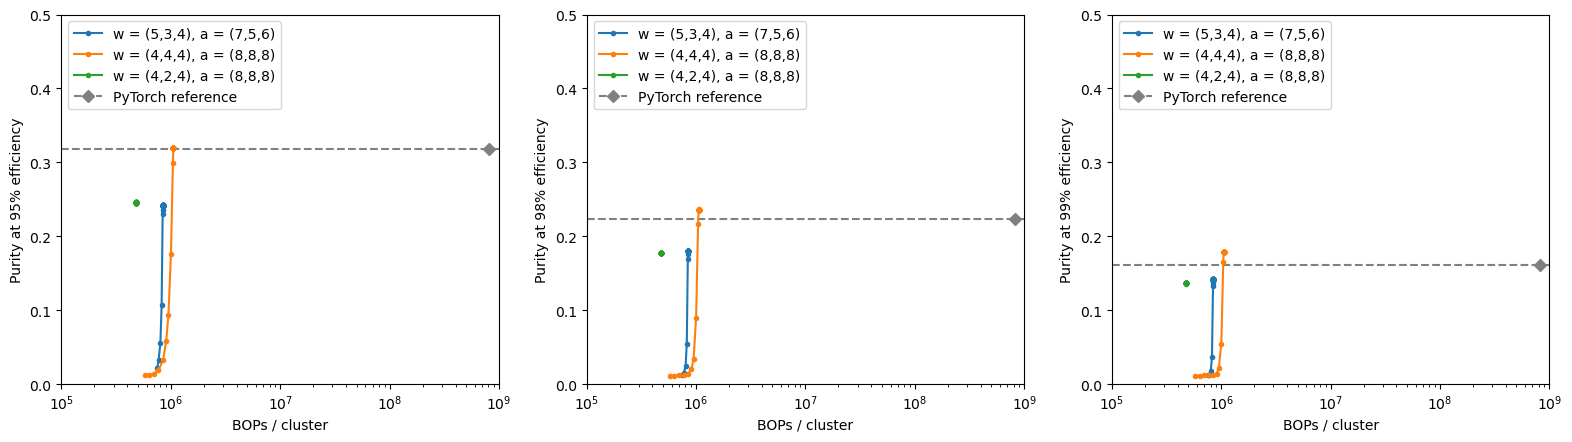

In [154]:

fig = plt.figure(figsize=(19.2,4.8))
ax1 = fig.add_subplot(131)
print(reference[0][0])
ax1.axline((1e8,reference[0][0]),(1e9,reference[0][0]),linestyle = 'dashed', color = "gray")
ax2 = fig.add_subplot(132)
ax2.axline((1e8,reference[1][0]),(1e9,reference[1][0]),linestyle = 'dashed', color = "gray")
ax3 = fig.add_subplot(133)
ax3.axline((1e8,reference[2][0]),(1e9,reference[2][0]),linestyle = 'dashed', color = "gray")
ax_list = [ax1, ax2, ax3]

# pruned MLP with references
for pur_file, graph_label  in zip(qmlp_pur_vs_bops, label_files_qmlp_prune):
    for ax, lab, pur, ref in zip (ax_list, purity_labels, pur_file, reference):
        ax.set_ylabel(lab)
        ax.set_xscale('log')
        ax.set_ylim(y_min,y_max)
        ax.set_xlim(x_min,x_max)
        ax.set_xlabel("BOPs / cluster")
        ax.plot(pur_file[3],pur, label = graph_label, alpha=1, marker = ".") #, linestyle=linestyles[idfile%3], marker = markerstyles[idfile%3]) ##plotting )
        if(pur_file == qmlp_pur_vs_bops[-1]):
            ax.plot(reference[3], ref, label = reference_label, alpha=1, marker = "D", linestyle="dashed", color = "gray")
        ax.legend(loc=2, prop={'size': 10})


0.317711740732193


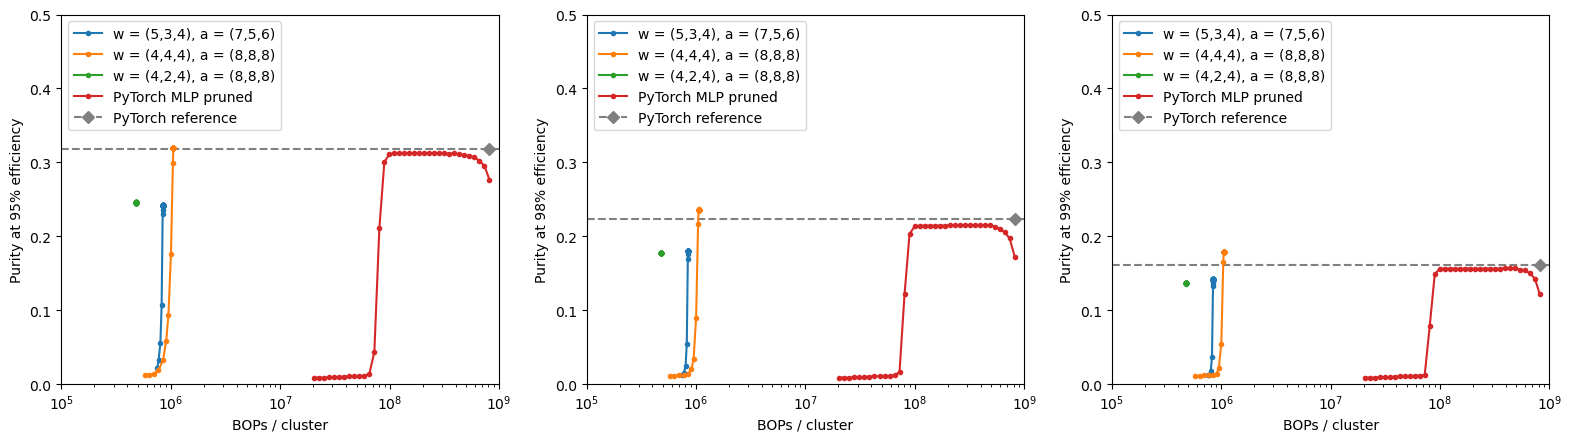

In [153]:

fig = plt.figure(figsize=(19.2,4.8))
ax1 = fig.add_subplot(131)
print(reference[0][0])
ax1.axline((1e8,reference[0][0]),(1e9,reference[0][0]),linestyle = 'dashed', color = "gray")
ax2 = fig.add_subplot(132)
ax2.axline((1e8,reference[1][0]),(1e9,reference[1][0]),linestyle = 'dashed', color = "gray")
ax3 = fig.add_subplot(133)
ax3.axline((1e8,reference[2][0]),(1e9,reference[2][0]),linestyle = 'dashed', color = "gray")
ax_list = [ax1, ax2, ax3]

# pruned MLP with references
for pur_file, graph_label in zip(qmlp_pur_vs_bops, label_files_qmlp_prune):
    for ax, lab, pur, ref, mlp_pur in zip (ax_list, purity_labels, pur_file, reference, pur_vs_bops[1]):
        ax.set_ylabel(lab)
        ax.set_xscale('log')
        ax.set_ylim(y_min,y_max)
        ax.set_xlim(x_min,x_max)
        ax.set_xlabel("BOPs / cluster")
        ax.plot(pur_file[3],pur, label = graph_label, alpha=1, marker = ".") #, linestyle=linestyles[idfile%3], marker = markerstyles[idfile%3]) ##plotting )
        if(pur_file == qmlp_pur_vs_bops[-1]):
            ax.plot(pur_vs_bops[1][3], mlp_pur, alpha=1, marker = ".", label = "PyTorch MLP pruned")
            ax.plot(reference[3], ref, label = reference_label, alpha=1, marker = "D", linestyle="dashed", color = "gray")
        ax.legend(loc=2, prop={'size': 10})
